In [1]:
from collections import Counter as counter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv
import numpy as np
import os
import scipy
import matplotlib.path as mplPath
import random
from matplotlib.ticker import NullFormatter, MaxNLocator
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon as polygonPatch
from numpy import linspace
import urllib2
import json
import unidecode
import re
import math
import sys
import shapefile as shp
from math import radians, cos, sin, asin, sqrt

import pyproj    
import shapely
import shapely.ops as ops
from shapely.geometry.polygon import Polygon
from functools import partial
import scipy.linalg

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist

In [2]:
# This file determines:
# 1. The census tract that each building lies in
buildingIds = []
buildingTracts = {}
buildingsProcessed = 0

#### The demo tract is located in the Back bay area of Boston, the tractId is 25025010702

In [3]:
### demo with tract 25025010702
### dictionary of coordinates for each cencus tract
tractCoordinates = {}
with open('../Data/demoTract.csv', 'r') as f:
    print f.readline()
    for line in f:
        if line.split(',')[0] == '25025010702':
            coordinates = line.split('<coordinates>')[1]
            coordinates = coordinates.split('</coordinates>')[0]
            coordinates = coordinates.split(' ')
            coordinates = [x.split(',') for x in coordinates]
            coordinates = [[float(x[0]), float(x[1])] for x in coordinates]
            tractId = line.split(',')[0]
            tractCoordinates[tractId] = coordinates

GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,POP100_RE,kmlgeometry



In [4]:
tracts = tractCoordinates.keys()

In [5]:
sf = shp.Reader("../Data/SDL_Buildings/demoTractBuildings.shp")
fields = sf.fields
shapes = sf.shapes()
records = sf.records()

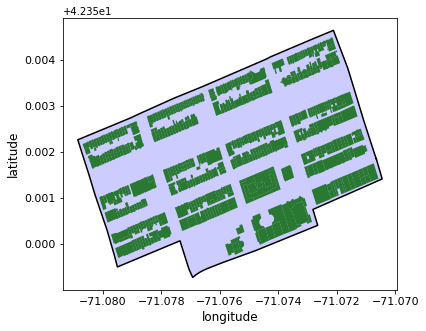

In [6]:
### Plot the tract and the buildings to see what we have
fig = plt.figure()
fig.set_size_inches(6,5)
ax1 = fig.add_subplot(111)

for tractId in tracts:
    geom = np.array( tractCoordinates[tractId] )
    ax1.plot(geom[:,0], geom[:,1], color='k')
    ptchs = []
    poly = polygonPatch(geom)
    ptchs.append(poly)
    ax1.add_collection(PatchCollection(ptchs,facecolor='b', alpha=0.2, edgecolor='none'))

# plot the building shape file
ptchs = []
for areas in shapes:
    x=[area[0] for area in areas.points]
    y=[area[1] for area in areas.points]
    pols = zip(x,y)
    poly = polygonPatch(pols)
    ptchs.append(poly)
ax1.add_collection(PatchCollection(ptchs,facecolor='darkgreen', alpha=0.8, edgecolor='none'))
fs = 12
ax1.set_ylabel('latitude', fontsize=fs)
ax1.set_xlabel('longitude', fontsize=fs)
ax1.tick_params(axis='both', labelsize=fs-1)

In [7]:
### Now open the file that relates contains the use per floor areas for the buildings in the shapefile
### There are two ids, objectID is the distinct shape and SDLID is for the building. 
### Buildings may be comprised of more than one object
### SDL ---> Christoph Reinhart's Sustainable Design Lab @ MIT
SDLIds = []
objectIds = []
with open('../Data/SDL_Buildings/BBXX_USEAREA_POL.txt', 'r') as f:
    f.readline()
    for line in f:
        line = line.replace("\"", "")
        line = line.replace("\r\n", "")
        line = line.split(',')
        SDLIds.append(line[1])
        objectIds.append(line[0])

In [8]:
def pointInsidePolygon(point, polygon):
    X = [x[0] for x in polygon]
    Y = [x[1] for x in polygon]
    if point[0]>=min(X) and point[0]<=max(X) and \
       point[1]>=min(Y) and point[1]<=max(Y):
        polygon = mplPath.Path(np.array(polygon))
        return polygon.contains_point(point)
    else:
        return 0

In [9]:
# Determining the Census Tract that each building lies in
# Storing the list of buildings outside any census tract
g = open('../Intermediate_Results/buildings_noTract.txt', 'w')
with open('../Intermediate_Results/building_Tracts.txt', 'w') as f:
    counter = 0
    for j,entry in enumerate(records):
        # -1 is the objectId
        if entry[-1] in objectIds:
            counter += 1
            buildingIds.append(entry[-1])
            shape = shapes[j]
            x=[area[0] for area in shape.points]
            y=[area[1] for area in shape.points]
            shapeCoords = zip(x,y)
            longitude, latitude = np.mean(shapeCoords, axis=0)
            #print longitude, latitude
            found = 0
            for t in tractCoordinates.keys():
                if pointInsidePolygon([longitude, latitude], \
                                      tractCoordinates[t]):
                    buildingTracts[entry[-1]] = t
                    f.write(entry[-1]+ ',' + t + '\n')
                    found = 1
                    break
            if not found:
                g.write(entry[-1] + '\n')                    
g.close()
print 'there are ', counter, 'buildings with shapes and info'

there are  471 buildings with shapes and info


In [10]:
buildingIds = []
with open('../Intermediate_Results/building_Tracts.txt', 'rb') as f:
    for line in f:
        line = line.strip().split(',')
        buildingIds.append(line[0])

In [11]:
print 'There are', len(set(buildingIds)), 'buildings in relevant tracts'

There are 471 buildings in relevant tracts
